# **EfficientNet B5,B6 and B7 Model using Tensorflow 2**

This notebook has been largely derived from AgentAuers's notebook : https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

### **Params/Configs Specification**

In [1]:
DEVICE = "TPU"

CFG = dict(
    batch_size        =  12,
    
    read_size         = 384, 
    crop_size         = 376, 
    net_size          = 384,
    
    #LR_START          =   0.000005,
    LR_START          =   0.000003,
    LR_MAX            =   0.000020,
    LR_MIN            =   0.000001,
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    epochs            =  14,
    
    rot               = 180.0,
#     shr               =   2.0,
#     hzoom             =   8.0,
#     wzoom             =   8.0,
#     hshift            =   8.0,
#     wshift            =   8.0,
    shr               =   1.5,
    hzoom             =   6.0,
    wzoom             =   6.0,
    hshift            =   6.0,
    wshift            =   6.0,

    optimizer         = 'adam',
    label_smooth_fac  =   0.05,
    
    tta_steps         =  25    
)

### **Install EfficientNet**

In [2]:
!pip install -q efficientnet

### **Import Required Libraries**

In [3]:
import os, random, re, math, time
# random.seed(a=42)

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

import PIL

from tqdm import tqdm

In [4]:
SEED = 702

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [5]:
seed_everything(SEED)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### **Read the data**

In [7]:
Kaggle = False
Colab = !Kaggle

In [8]:
import os, sys
from pathlib import Path

if Colab:
    from google.colab import drive
    drive.mount('/content/drive')

    path = "/content/drive/My Drive"
    os.chdir(path)
    os.listdir(path)
else:
    from kaggle_datasets import KaggleDatasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
if Kaggle:
    BASEPATH = "../input/siim-isic-melanoma-classification"
    outdir = '.'
else:
    PATH = 'siim/'
    BASEPATH = PATH + 'siim-isic-melanoma-classification'
    outdir = Path(PATH+'res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = Path(PATH+'res/efficientnet-res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)

In [10]:
MODELNAME = "EF6-7-512"
VERSION = '{}'.format(MODELNAME)
outdir = os.path.join(outdir, VERSION)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [11]:
from datetime import datetime, timedelta
dateTimeObj = datetime.now()
# timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H")
timestampStr = 'all-kfold'
outdir = os.path.join(outdir, timestampStr)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [12]:

df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv.zip'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))
if Kaggle:  
    GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
else:
    # GCS_PATH    = 'gs://kds-15058c9547e52366a943e43398c80deea2216be99acb2f5c15aa3795' #256*256
    # GCS_PATH    = 'gs://kds-8e70e0cf98cd454e001e3427408ecabe6ed37ce76454038f17429c70' #384*384
    GCS_PATH    = 'gs://kds-c03d4b26f00dd6737e467fc94fb9f1e27f23d52eefc9137f8c8e0463' #512*512
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

### **TPU Configuration**

In [13]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
#REPLICAS = 8
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.92.42.138:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.92.42.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.92.42.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [14]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [15]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, cfg=None, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [16]:
def get_dataset(files, cfg, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

### **Test Input Pipeline**

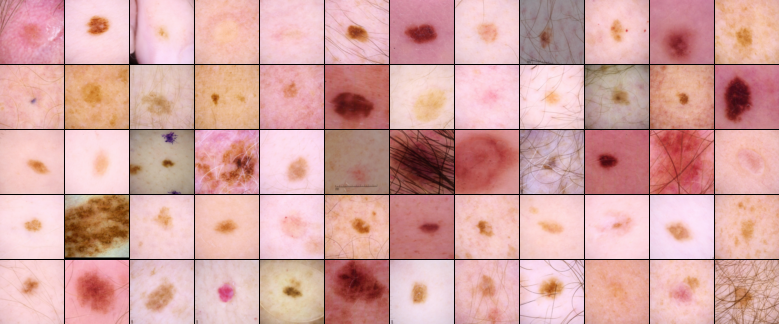

In [17]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

### **Image Augmentation**

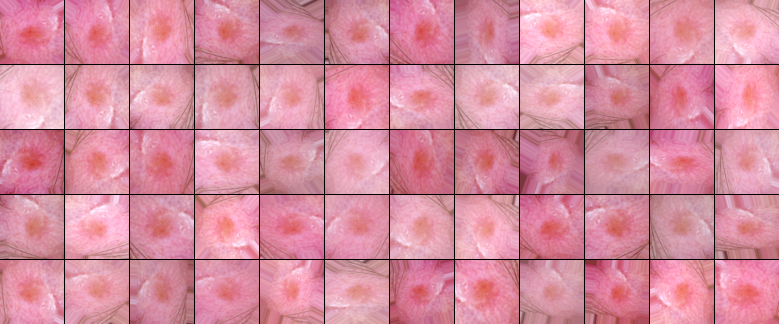

In [18]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

### **Test Data Images**

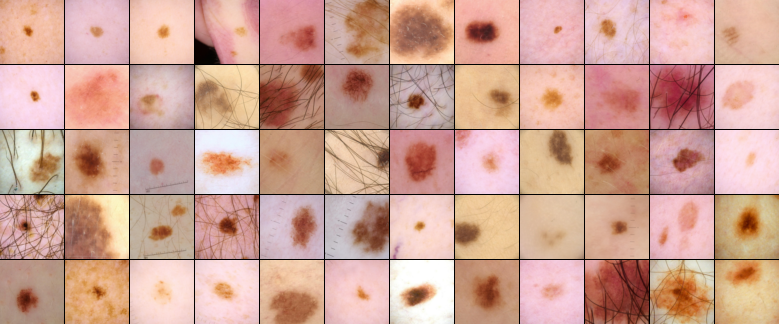

In [19]:
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

In [20]:
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

### **Build Model**

In [21]:
def get_model(cfg, model):
    
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)    
    outputs = []    

    constructor = getattr(efn, model)
    x = constructor(include_top=False, weights='imagenet', 
                    input_shape=(cfg['net_size'], cfg['net_size'], 3), 
                    pooling='avg')(dummy)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    
    return model


### **Compile Model**

In [22]:
def compile_new_model(cfg, model):    
    with strategy.scope():
        model = get_model(cfg, model)
     
        losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])
        
        model.compile(
            optimizer = cfg['optimizer'],
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model

### **Fit Model**

In [23]:
from sklearn.model_selection import KFold

In [24]:
folds = 5
# kfold = KFold(folds, shuffle = True, random_state = SEED)
# TRAIN_FOLD = 4
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(files_train)):
#     if fold != TRAIN_FOLD:
#       continue
#     print('\n')
#     print('-'*50)
#     print(f'Training fold {fold + 1}')
#     subfiles_train = [files_train[x] for x in trn_ind]
#     subfiles_val = [files_train[x] for x in val_ind]
#     ds_train     = get_dataset(subfiles_train, CFG, augment=True, shuffle=True, repeat=True)
#     ds_train     = ds_train.map(lambda img, label: (img, tuple([label])))
#     steps_train  = count_data_items(subfiles_train) / (CFG['batch_size'] * REPLICAS)
#     ds_val     = get_dataset(subfiles_val, CFG, augment=False, shuffle=False, repeat=False)
#     ds_val     = ds_val.map(lambda img, label: (img, tuple([label])))

In [25]:
# # ds_train     = get_dataset(subfiles_train, CFG, augment=True, shuffle=True, repeat=True)
# # ds_train     = ds_train.map(lambda img, label: (img, tuple([label])))

# # steps_train  = count_data_items(subfiles_train) / (CFG['batch_size'] * REPLICAS)

# #model_B5      = compile_new_model(CFG, 'EfficientNetB5')
# model_B6      = compile_new_model(CFG, 'EfficientNetB6')

# print("\n Begin Training Models") 
# # history_B5     = model_B5.fit(ds_train, 
# #                          verbose          = 1,
# #                          steps_per_epoch  = steps_train, 
# #                          epochs           = CFG['epochs'],
# #                          callbacks        = [get_lr_callback(CFG)])
# # print("\n Done Training model_B5 \n")
# history_B6     = model_B6.fit(ds_train, 
#                          verbose          = 1,
#                          steps_per_epoch  = steps_train, 
#                          epochs           = CFG['epochs'],
#                          validation_data = ds_val,
#                          callbacks        = [get_lr_callback(CFG)])
# print("\n Done Training model_B6 \n")
# hist_df = pd.DataFrame(history_B6.history) 
# hist_df.to_csv(os.path.join(outdir,'history-b6-{}.csv'.format(TRAIN_FOLD)))
# model_B6.save(os.path.join(outdir,'bestmodelb6-{}.hdf5'.format(TRAIN_FOLD)))

In [26]:
# model_B7      = compile_new_model(CFG, 'EfficientNetB7')
# history_B7     = model_B7.fit(ds_train, 
#                          verbose          = 1,
#                          steps_per_epoch  = steps_train, 
#                          epochs           = CFG['epochs'],
#                          validation_data = ds_val,
#                          callbacks        = [get_lr_callback(CFG)])
# print("\n Done Training model_B7 \n")
# hist_df = pd.DataFrame(history_B7.history) 
# hist_df.to_csv(os.path.join(outdir,'history-b7-{}.csv'.format(TRAIN_FOLD)))
# model_B7.save(os.path.join(outdir,'bestmodelb7-{}.hdf5'.format(TRAIN_FOLD)))

### **Predict**

In [27]:
# CFG['batch_size'] = 128

# cnt_test   = count_data_items(files_test)
# steps      = cnt_test / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
# ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
#                          labeled=False, return_image_names=False)

# #preds_B5 = model_B5.predict(ds_testAug, verbose=1, steps=steps)
# preds_B6 = model_B6.predict(ds_testAug, verbose=1, steps=steps)
# preds_B7 = model_B7.predict(ds_testAug, verbose=1, steps=steps)

In [28]:
# print("Test shape :",df_sub.shape)
# #print("Preds shape :",preds_B5.shape)
# print("Preds shape :",preds_B6.shape)
# print("Preds shape :",preds_B7.shape)

In [29]:
# preds = np.stack(preds_B5)
# preds = preds[:,:cnt_test* CFG['tta_steps']]
# preds = preds[:df_test.shape[0]*CFG['tta_steps']]
# preds = np.stack(np.split(preds, CFG['tta_steps']),axis=1)
# preds = np.mean(preds, axis=1)
# preds_B5 = preds.reshape(-1)

In [30]:
# preds = np.stack(preds_B6)
# preds = preds[:,:cnt_test* CFG['tta_steps']]
# preds = preds[:df_test.shape[0]*CFG['tta_steps']]
# preds = np.stack(np.split(preds, CFG['tta_steps']),axis=1)
# preds = np.mean(preds, axis=1)
# preds_B6 = preds.reshape(-1)
# df = pd.DataFrame(preds_B6, columns =['P6_{}'.format(TRAIN_FOLD)]) 
# df.to_csv(os.path.join(outdir,'preds-b6-{}.csv'.format(TRAIN_FOLD)))

In [31]:
# preds = np.stack(preds_B7)
# preds = preds[:,:cnt_test* CFG['tta_steps']]
# preds = preds[:df_test.shape[0]*CFG['tta_steps']]
# preds = np.stack(np.split(preds, CFG['tta_steps']),axis=1)
# preds = np.mean(preds, axis=1)
# preds_B7 = preds.reshape(-1)
# df = pd.DataFrame(preds_B7, columns =['P7_{}'.format(TRAIN_FOLD)]) 
# df.to_csv(os.path.join(outdir,'preds-b7-{}.csv'.format(TRAIN_FOLD)))

In [32]:
# preds = preds_B6*0.6 + preds_B7*0.4

In [33]:
preds6 = []
preds7 = []
for i in range(folds):
    preds_B6 = pd.read_csv(os.path.join(outdir,'preds-b6-{}.csv'.format(i)))
    # preds_B7 = pd.read_csv(os.path.join(outdir,'preds-b7-{}.csv'.format(i)))
    # print(display(preds_B6.head()))
    # print(display(preds_B7.head()))
    preds6.append(preds_B6['P6_{}'.format(i)].values.tolist())
    # preds7.append(preds_B7['P7_{}'.format(i)].values.tolist())

In [34]:
print(np.shape(preds6))
preds_B6 = np.mean(preds6, axis=0)
# preds_B7 = np.mean(preds7, axis=0)
# preds = preds_B6* 0.5 + preds_B7*0.5
preds = preds_B6

(5, 10982)


In [35]:
print(preds)

[0.0277686  0.02790811 0.02626396 ... 0.02246847 0.03130483 0.02767291]


### **Make Submission**

In [36]:
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [37]:
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = preds))

submission = submission.sort_values('image_name') 
submission.to_csv(os.path.join(outdir, 'submission_EfficientNet_Blend_6-kfold.csv'), index=False)

submission.head()

,image_name,target
9905,ISIC_0052060,0.030423
1443,ISIC_0052349,0.022737
3120,ISIC_0058510,0.027381
4870,ISIC_0073313,0.027529
5494,ISIC_0073502,0.031398


In [38]:
# model_B6.save(os.path.join(outdir,'bestmodelb6.hdf5'))

In [39]:
# model_B7.save(os.path.join(outdir,'bestmodelb7.hdf5'))

In [40]:
print(outdir)

siim/res/efficientnet-res/EF6-7-512/all-kfold


In [41]:
display(df_train)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [42]:
df_train['sex'] = df_train['sex'].fillna('na')
df_train['age_approx'] = df_train['age_approx'].fillna(0)
df_train['anatom_site_general_challenge'] = df_train['anatom_site_general_challenge'].fillna('na')

df_test['sex'] = df_test['sex'].fillna('na')
df_test['age_approx'] = df_test['age_approx'].fillna(0)
df_test['anatom_site_general_challenge'] = df_test['anatom_site_general_challenge'].fillna('na')

In [43]:
L = 15
feat = ['sex','age_approx','anatom_site_general_challenge']

M = df_train.target.mean()
te = df_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
del te['mean'], te['count']

df_test = df_test.merge( te, on=feat, how='left' )
df_test['ll'] = df_test['ll'].fillna(M)

df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,ll
0,ISIC_0052060,IP_3579794,male,70.0,na,0.008530
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.008428
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.014630
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.008416
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.007548


In [44]:
submission = pd.read_csv(os.path.join(outdir,'submission_EfficientNet_Blend_6-kfold.csv'))
submission.target = submission.target*0.6 + df_test.ll.values* 0.4
submission.head(10)
submission.to_csv(os.path.join(outdir, f'submission_EfficientNet_Blend_6_kfold_meta.csv'), index=False)

In [45]:
submission.head(10)

,image_name,target
0,ISIC_0052060,0.021666
1,ISIC_0052349,0.017013
2,ISIC_0058510,0.022281
3,ISIC_0073313,0.019884
4,ISIC_0073502,0.021858
5,ISIC_0074618,0.024240
6,ISIC_0076801,0.025551
7,ISIC_0077586,0.019720
8,ISIC_0082004,0.021146
9,ISIC_0082785,0.022318
